# Introducción

Este *notebook* incluye:
- Pequeños ejemplos de uso de *pandas*.
- Un *DataSet* (de *PyTorch*) que almacena información de los archivos de audio con los cantos de las aves. Este *DataSet*, al solicitársele el i-ésimo *item*, devuelve un cacho del i-ésimo audio, un cacho de un j-ésimo audio, y un 0 o 1 si `i != j` o `i == j` respectivamente.
- Un *DataLoader* (de *PyTorch*) que envuelve al *DataSet* previamente descrito.
- 

### Importaciones

Importación de las bibliotecas a utilizar, y una pequeña descripción de cada una.

In [1]:
# pandas is an open source data analysis and manipulation tool.
import pandas as pd

# NumPy is for scientific computing with Python
import numpy as np

# PyTorch is an open source machine learning framework.
import torch

# PyTorch provides the torch.nn module to help us
# in creating and training of the neural network.
import torch.nn as nn

# PyTorch has two primitives to work with data:
# torch.utils.data.Dataset stores the samples and their corresponding labels.
# torch.utils.data.DataLoader wraps an iterable around the Dataset.
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# "The easiest way to use deep metric learning in your application".
# Written in PyTorch.
# https://github.com/KevinMusgrave/pytorch-metric-learning
from pytorch_metric_learning import losses

# librosa is for music and audio analysis; it provides
# the building blocks necessary to create music
# information retrieval systems.
import librosa

# Displays a spectrogram/chromagram/cqt/etc.
from librosa.display import specshow

# matplotlib.pyplot is a collection of functions that make
# matplotlib work like MATLAB. Each pyplot function makes
# some change to a figure: e.g., creates a figure, creates
# a plotting area in a figure, plots some lines in a plotting
# area, decorates the plot with labels, etc.
import matplotlib.pyplot as plt

# TensorBoard is a visualization toolkit for machine learning
# experimentation. TensorBoard allows tracking and visualizing
# metrics such as loss and accuracy, visualizing the model graph,
# viewing histograms, displaying images and much more.
from torch.utils.tensorboard import SummaryWriter

# Para tomar el tiempo que toman ciertos procesos de la siguiente manera:
# start = timer()
# (algún proceso)
# end = timer()
# El tiempo en segundos es end-start.
from timeit import default_timer as timer

# CUDA-accelerated PyTorch implementation of the
# T-Stochastic Neighbor Embedding algorithm.
#from tsne_torch import TorchTSNE as TSNE

# Manejo de guardado y cargado de objetos mediante archivos.
import pickle

# Manejo de pseudo-aleatoriedad.
import random

# Manejo de funciones matemáticas.
import math

# Manejo de fecha y tiempo.
from datetime import datetime

### Variables generales

Variables generales/globales que se utilizarán a lo largo del *notebook*. Conviene tener este apartado para consultarlas y modificarlas fácilmente.

In [2]:
# Uso del GPU, si está disponible.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilizando {device} para el procesamiento de datos.")

# Cadena con la ubicación del archivo CSV que contiene
# el DataFrame con datos de los audios de aves.
birds_csv = "/media/birds/BirdsDataFrame.csv"

# Cadena con la ubicación de los archivos WAV y XML
# correspondientes a los audios de aves a procesar.
birds_path = "/media/birds/data/"

# Otras ubicaciones útiles.
DIR_runs = "./runs/"
DIR_objects = DIR_runs+"python_objects/"
DIR_tensorboard = DIR_runs+"tensorboard/"
DIR_notebooks = DIR_runs+"notebooks/"
DIR_models = DIR_runs+"models/"

# Nombre de la columna, dentro del DataFrame,
# que contiene el nombre de los archivos de audio.
file_col_name = "FileName"

# DataFrame (de 'pandas') del archivo CSV dado.
birds_df = pd.read_csv(birds_csv)

# Los audios de aves se cortarán en cachos cuya longitud
# varíe entre len_min segundos y len_max segundos.
len_min = 1
len_max = 1

# Ancho y alto de cada espectrograma.
# TO-DO: ¿Es posible calcular esto mediante una fórmula? Resulta del size()/shape de aplicar "stft" al audio "y".
ancho,alto = 1025,87

# Número de canales que tendrá cada audio.
# Hasta ahora, si un audio tiene 1 canal, y aquí se
# especifican 2, se copia el primer canal en un
# segundo canal. Si un audio tiene más de 2 canales,
# la operación no está definida.
audio_channels = 2

# Frecuencia de muestreo a la cual TODOS los audios se
# muestrearán. Esto es necesario para que los vectores
# que representan a los audios tengan los mismos tamaños.
sr = 44100

# Probabilidad de que dos audios de aves (o
# cachos de audios) compartan cierta propiedad.
p_prop = 0.5

# Variables asociadas a la Red Neuronal.
batch_size = 64 # Número de muestras que se tomarán por lote/epoch.
epochs = 30 # Veces que se recorrerá el DataSet entero.
lr = 6e-05 # Learning Rate.
#momentum = 0.5 # The SGD momentum (default: 0.5) is the moving average of our gradients (helps to keep direction).

# Para TensorBoard, creamos un SummaryWriter.
# Éste escribiría al directorio ./runs/ por defecto.
dt_string = datetime.now().strftime("%Y-%m-%d-%H-%M")
writer = SummaryWriter(log_dir=DIR_tensorboard+dt_string+"_adbekunkus")

# Función a utilizar para procesar los audios de aves.
def librosa_process(path, cut, cut_len=None):
    """
    Función que carga un audio con Librosa y devuelve el vector
    unidimensional que representa al audio, y su frecuencia de muestreo.
    :param str path: Ruta donde se ubica el audio.
    :param bool cut: ¿Se cortará (y devolverá) sólo un cacho aleatorio del audio?
    :param float cut_len: Longitud del cacho de audio (si cut==True).
    """
    
    # Longitud del audio completo en segundos.
    audio_len = librosa.get_duration(filename=path)
    
    # Si se desea el audio completo, 'librosa' lo
    # cargará desde el inicio hasta el final.
    start = 0
    duracion = audio_len
        
    # Si se desea sólo un cacho del audio...
    if cut:
        
        # Determinamos la longitud del cacho
        # aleatorio de audio en segundos.
        duracion = cut_len if cut_len != None else random.uniform(len_min, len_max) # Rango [a,b].
        
        # Aseguramos que el audio completo es más
        # grande que el tamaño del cacho que queremos.
        assert audio_len > duracion
        
        # Definimos en dónde empezará
        # (aleatoriamente) el cacho de audio.
        start = random.uniform(0, audio_len-duracion) # Rango [a,b].
    
    # Obtenemos el audio-vector y su (nueva) frecuencia de muestreo.
    y, sampling_rate = librosa.load(path, sr=sr, offset=start, duration=duracion, mono=False)
    
    # Algunos audios fueron grabados en dos canales (stereo), y otros en
    # uno (mono). Convertimos los que fueron grabados en un canal en
    # audios de dos canales (al duplicar el único canal que tienen).
    if y.ndim == 1:
        y = np.repeat(y[np.newaxis, :], 2, axis=0)
    
    # Función no definida para audios que tienen más de dos canales.
    # Igual se lanza un error si los vectores no tienen la longitud adecuada (sr).
    assert(y.shape == (2, sr))
    
    # Short-time Fourier transform (STFT).
    # The STFT represents a signal in the time-frequency domain by computing
    # discrete Fourier transforms (DFT) over short overlapping windows.
    stft = librosa.stft(y)
    
    # This function (stft) returns a complex-valued matrix D such that
    # np.abs(D[..., f, t]) is the magnitude of frequency bin f at frame t.
    magnitude = np.abs(stft)
    
    # Converts an amplitude spectrogram to dB-scaled spectrogram.
    spectogram = librosa.amplitude_to_db(magnitude)
    
    # Devolvemos el espectrograma y su frecuencia de muestreo.
    return spectogram, sampling_rate

# Comprobaciones sobre las variables aquí definidas.
assert len_min <= len_max # Lógicamente, min<=max.
assert p_prop >= 0 and p_prop <= 1 # Las probabilidades se encuentran en este rango.

Utilizando cuda:0 para el procesamiento de datos.


### _pandas_

Dado que el archivo `birds_csv` cuenta con *N* columnas `columna0,columna1,...,columnaN-1`, imprimimos a continuación el nombre de cada columna, enumerándolas desde cero.

**NOTA**: La primera columna no tiene nombre, por lo que *pandas*, al convertir el archivo CSV en un *DataFrame* mediante la función `read_csv()`, le asigna el nombre `Unnamed: 0`. Esta columna sirve para indexar a las entradas dentro del archivo CSV (no confundir con la columna 'index' cuyo propósito es indexar a los archivos de audio de otra manera).

In [3]:
# Por cada columna del DataFrame, imprimimos dicha columna.
#for i,col in enumerate(birds_df.columns):
#    print(f"{i}:{col}")

Ejemplificamos con la primera entrada del archivo al imprimir qué valor tiene asociado a cada columna.

In [4]:
# "iloc" permite indexar por posiciones mediante el uso de enteros.
# Por cada columna y valor en la primera línea, imprimimos ambos.
#for col, val in birds_df.iloc[0].iteritems():
#    print(f"{col}:{val}")

Hay algunas columnas tal que todas las entradas del archivo comparten un mismo valor dentro de esa columna. A continuación imprimimos los nombres de las columnas que cumplen ésto, así como el valor que todas las entradas comparten en dicha columna.

In [5]:
# Por cada columna del DataFrame...
#for col in birds_df.columns:
    
    # Si todas las entradas tienen el mismo valor en dicha
    # columna, imprimimos la columna y el valor correspondiente.
    #if (birds_df[col] == birds_df[col][0]).all():
        #print(f"{col}:{birds_df[col][0]}")

# Definición del *DataSet*

Creamos el *DataSet* de *PyTorch* que guarda y maneja los datos de los archivos de audio (que contienen los cantos de las aves).

In [6]:
class CustomBirdDataset(Dataset):
    """
    Dataset de audios de aves.
    """
    
    def __init__(self, df, process_func, audio_path, transform=None, target_transform=None):
        """
        The __init__ function is run once when instantiating the Dataset object.
        """
        
        # 'df' es el DataFrame a almacenar.
        self.df = df
        
        # 'process_func' toma la ruta de un audio a procesar, y lo procesa.
        self.process_func = process_func
        
        # 'audio_path' es la ruta donde se ubican los archivos de audio.
        self.audio_path = audio_path
        
        # 'transform' and 'target_transform' modify the samples and labels respectively.
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """
        The __len__ function returns the number of samples in our dataset.
        """
        return len(self.df)

    def __getitem__(self, idx=None):
        """
        The __getitem__ function loads and returns a sample from the dataset at the given index 'idx'.
        """
        
        # Si no se especifica un índice, se toma una muestra aleatoria.
        if idx == None:
            idx = random.randrange(0, birds_ds.__len__()) # Rango [a,b).
        
        # Obtenemos la idx-ésima línea del DataFrame almacenado.
        # Y el nombre del archivo de audio a procesar.
        item = self.df.iloc[idx]
        filename = item[file_col_name]
        
        # Procesamos el primer cacho de audio.
        x,_ = self.process_func(self.audio_path+filename, True)
        
        # Si se desea que ambos cachos de audio compartan la propiedad,
        # sólo dejamos la etiqueta como "1", y volvemos a procesar
        # el mismo archivo de audio de manera aleatoria (más adelante).
        if (random.random() < p_prop):
            target = 1
            
        # Si, por otro lado, se desea que los cachos no compartan la
        # propiedad, dejamos la etiqueta como "-1", y buscamos otro
        # archivo de audio para procesar.
        else:
            target = 0
            
            # Guardamos la especie del ave del primer cacho de audio.
            primera_especie = item["Species"]
            
            # Quitamos el primer archivo de audio (que ya fue procesado) del
            # DataFrame (temporalmente), obtenemos algún renglón aleatorio de
            # este nuevo DataFrame (sample() devuelve un DataFrame, por lo que
            # es necesario tomar el primer renglón con iloc[0]), y obtenemos
            # el nombre del nuevo archivo de audio a procesar.
            item = self.df.drop(idx).sample().iloc[0]
            filename = item[file_col_name]
                  
            # Guardamos la especie del ave del segundo cacho de audio.
            segunda_especie = item["Species"]
            
            # TO-DO: Si son la misma especie, ¿sigo buscando otro segundo cacho
            # de audio, o cambio el "target" a 1? Por ahora sólo lo cambio a 1.
            #print(f"El primer cacho de audio pertenece a un ave {primera_especie}, y el segundo pertenece a un ave {segunda_especie}.")
            if primera_especie == segunda_especie:
                target = 1

        # Procesamos el segundo cacho de audio.
        y,_ = self.process_func(self.audio_path+filename, True)
            
        # NOTA:
        # Aún no se define el uso para 'transform' y 'target_transform'.
        # Una propuesta es que 'transform' sustituya a 'process_func'.
        
        # Devolvemos el primer cacho de audio, el segundo cacho de audio,
        # y la etiqueta que indica si ambos comparten (1) o no (0) la propiedad.
        return x, y, target

Cargamos el *DataSet* al pasarle:
- El *DataFrame* creado previamente con *pandas*.
- La función a utilizar para procesar los audios.
- La ruta del directorio en el cual se encuentran los archivos de audio.

In [7]:
birds_ds = CustomBirdDataset(birds_df, librosa_process, birds_path)

### Ejemplo del *DataSet*

Y obtenemos una muestra aleatoria del *DataSet* mediante su función `__getitem__()`.

In [8]:
#birds_ds.__getitem__()

# Definición del *DataLoader*

Creamos dos *DataLoader* de *PyTorch* que envuelven el *DataSet* previamente definido. Uno está definido para el entrenamiento, mientras que otro está definido para el testeo.

In [9]:
birds_dl_train = DataLoader(birds_ds, batch_size=batch_size, shuffle=True, drop_last=True)
birds_dl_test = DataLoader(birds_ds, batch_size=batch_size, shuffle=True)

### Ejemplo del **DataLoader**

El *DataLoader* contiene listas (que regresa la función `__getitem__()` correspondiente al *DataSet*). Estas listas contienen los lotes de tamaño `batch_size` y, para abarcar todos los datos, contiene aproximadamente `tamaño_de_todos_los_datos/batch_size` listas.

In [10]:
#print(f"- Tamaño del DataSet (de PyTorch) = {len(birds_ds)} = {len(birds_df)} = Tamaño del DataFrame (de pandas)")
#print(f"- Tamaño del DataLoader (de PyTorch): {len(birds_dl)}")
#iterador = iter(birds_dl)
#primer_lote = next(iterador)
#print(f"- Tamaño de la primera lista del DataLoader: {len(primer_lote)}")
#print(f"- Tamaño de los elementos de la primera lista: {len(primer_lote[0])} {len(primer_lote[1])} {len(primer_lote[2])}")
#print(f"- Tamaño del DataLoader por el tamaño de cada lote: {len(birds_dl)*batch_size} ≈ {len(birds_ds)}")

Imprimimos datos sobre el primer lote para ejemplificar.

In [11]:
#primeros_cachos, segundos_cachos, labels = primer_lote
#print(f"- Los primeros cachos de audio del primer lote tienen tamaño: {primeros_cachos.size()}")
#print(f"- Los segundos cachos de audio del primer lote tienen tamaño: {segundos_cachos.size()}")
#print(f"- Las etiquetas del primer lote tienen tamaño: {labels.size()}")
#print(f"- Etiquetas del primer lote: {labels}")
#print(f"- Primeros cachos del primer lote: {primeros_cachos}")
#print(f"- Segundos cachos del primer lote: {segundos_cachos}")

# Definición de la Red Neuronal

In [12]:
# nn.Module is the base class for all neural network modules.
# Our models should also subclass this class.
# Modules can also contain other Modules, allowing to nest them in a tree structure.
class RN(nn.Module):
    """
    Red Neuronal.
    """
    
    #This defines the structure of the NN.
    def __init__(self):
        """
        Inicialización de la Red Neuronal.
        Aquí se define su estructura.
        """
        
        #
        super().__init__()
        
        # Inicio de las capas convolucionales.
        conv_layers = []
        
        # Primera capa convolucional.
        self.conv1 = nn.Conv2d(in_channels=audio_channels, out_channels=batch_size, kernel_size=(10,10))
        self.relu1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        conv_layers += [self.conv1, self.relu1, self.mp1]
        
        # Segunda capa convolucional.
        self.conv2 = nn.Conv2d(batch_size, batch_size, kernel_size=(7,7))
        self.relu2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        conv_layers += [self.conv2, self.relu2, self.mp2]
        
        # Tercera capa convolucional.
        self.conv3 = nn.Conv2d(batch_size, batch_size, kernel_size=(4,4))
        self.relu3 = nn.ReLU()
        conv_layers += [self.conv3, self.relu3]
        
        # Fin de las capas convoluciones.
        self.conv = nn.Sequential(*conv_layers)
        
        # Inicio de las capas lineales (fully-connected).
        fc_layers = []
        
        # Primera capa lineal.
        # TO-DO: Determinar entrada.
        # TO-DO: Determinar salida.
        self.fc1 = nn.Linear(13,13)
        fc_layers += [self.fc1]
        
        # Segunda capa lineal.
        # TO-DO: Determinar entrada.
        # TO-DO: Determinar salida. ¿Es 1 valor para cada entrada?
        self.fc2 = nn.Linear(4063232, 1)
        # Ésta no se agrega a las demás,
        # pues no se aplica individualmente a
        # cada entrada; primero es necesario
        # realizar la operación de distancia
        # sobre éstas para después aplicar
        # esta capa lineal.
        
        # Fin de las capas lineales.
        self.fc = nn.Sequential(*fc_layers)
    
    def invididual_process(self, z):
        
        start = timer()
        z = self.conv(z)
        end = timer()
        #print(f"\t\t[time] Capas convolucionales: time={end-start}s out_size={z.size()}") # DEBUG
        
        start = timer()
        z = self.fc(z)
        end = timer()
        #print(f"\t\t[time] Capas lineales: time={end-start}s out_size={z.size()}") # DEBUG
        
        return z

    def forward(self, x, y):
        
        # TO-DO: Analizar las múltiples dimensiones en 2 o 3 dimensiones.
        #TSNE(n_components=2, verbose=True).fit_transform(x)
        
        #print(f"\tProcesando x: {x.size()}") # DEBUG
        x = self.invididual_process(x)
        #print(f"\tProcesando y: {y.size()}") # DEBUG
        y = self.invididual_process(y)
        
        # Para que 'x' y 'y' tengan sólo una dimensión...
        x = x.view(batch_size, -1)
        #print(f"\t\tx shape: {x.size()}") # DEBUG
        y = y.view(batch_size, -1)
        #print(f"\t\ty shape: {y.size()}") # DEBUG
        
        return x, y

# Definición del modelo.
red = RN().to(device)

# Entrenamiento de la Red Neuronal

In [13]:
# The loss function is the quantity that will be
# minimized during training.
# TO-DO: Escoger 'loss' adecuado.
#loss_func = losses.ContrastiveLoss().to(device)
loss_func = nn.CosineEmbeddingLoss().to(device)

# The optimizer determines how the network will be
# updated based on the loss function.
# TO-DO: Escoger 'optimizer' adecuado.
#optimizer = torch.optim.SGD(red.parameters(), lr=lr, momentum=momentum) # Usado por MNIST Colab.
optimizer = torch.optim.Adam(red.parameters(), lr = lr) # Usado por AlexNet (TMLoss y MSELoss).

# Para obtener estadísticas del entrenamiento.
loss_history = []
epoch_timing = []

def train(epoch):
    """
    Entrenamiento de la RN.
    """
    
    # Inicio, en segundos, del epoch.
    epoch_start = timer()
    
    # Imprimimos el número de epoch.
    print(f"Epoch {epoch}...")
    for batch_idx, data in enumerate(birds_dl_train):
        
        # DEBUG.
        print(f"\tProcesando lote {batch_idx+1}/{len(birds_dl_train)}...")
        
        # 'data' es una lista que representa un lote:
        # data[0] contiene los primeros cachos de audio.
        # data[1] contiene los segundos cachos de audio.
        # data[2] contiene las etiquetas.
        for i,d in enumerate(data):
            data[i] = d.to(device)
            
        # Convertimos las etiquetas a tipo flotante.
        # Necesario para la función de pérdida BCE.
        #data[2] = data[2].to(torch.float32)
        # TO-DO: ¿Ya no se usará BCE?
            
        # Vaciamos los gradientes para este lote.
        optimizer.zero_grad()
        # In PyTorch, for every mini-batch during the training phase,
        # we typically want to explicitly set the gradients to zero
        # before starting to do backpropragation (i.e., updating the
        # Weights and biases) because PyTorch accumulates the gradients
        # on subsequent backward passes.
        
        # Metemos los datos a la red neuronal.
        output_x, output_y = red(data[0], data[1])
        
        # TO-DO: Describir.
        
        start = timer()
        loss = loss_func(output_x, output_y, data[2])
        end = timer()
        #print(f"\t[time] Loss function: {end-start}s") # DEBUG
        
        start = timer()
        loss.backward() #dloss/dx for every variable
        end = timer()
        #print(f"\t[time] Loss backward: {end-start}s") # DEBUG
        
        # TensorBoard.
        writer.add_scalar("Loss/train", loss, epoch)
        
        start = timer()
        optimizer.step() #to do a one-step update on our parameter.
        end = timer()
        #print(f"\t[time] Optimizer step: {end-start}s") # DEBUG
        
        # Guardamos estadísticas del entrenamiento.
        loss_history.append(loss.item())
        
        
        # DEBUG:
        print(f"\tLoss: {loss}")
        #print(f"\tEtiquetas: {data[2]}")
        #print(f"\tOutput: {output}")
        print()
        
        #break # DEBUG: Permite el entrenamiento de sólo un lote.
    
    # Fin, en segundos, del epoch.
    epoch_end = timer()
    
    # Tiempo total, en segundos, del epoch.
    epoch_time_seconds = epoch_end-epoch_start
    epoch_timing.append(epoch_time_seconds)
    
    # DEBUG:
    print(f"[time] Epoch {epoch}: {epoch_time_seconds}s = {epoch_time_seconds/(60)}m")
    print()
    
# red.train() le indica al modelo que está siendo entrenado.
# Esto ayuda con capas como Dropout y BatchNorm, que están
# diseñadas para comporsarse distinto durante entrenamiento
# y evaluación.
red.train()
    
# Ejecutamos el entrenamiento definido, "epochs" veces.
train_start = timer()
for epoch in range(1, epochs+1): # Rango [a, b)
    train(epoch)
    #break # DEBUG: Permite la ejecución de sólo un epoch.
train_end = timer()

# Call flush() method to make sure that all pending events have been written to disk.
# If you do not need the summary writer anymore, call close() method.
writer.flush()
writer.close()

Epoch 1...
	Procesando lote 1/51...
	Loss: 0.014013148844242096

	Procesando lote 2/51...
	Loss: 0.007976519875228405

	Procesando lote 3/51...
	Loss: 0.008701885119080544

	Procesando lote 4/51...
	Loss: 0.005770036019384861

	Procesando lote 5/51...
	Loss: 0.005323364399373531

	Procesando lote 6/51...
	Loss: 0.005581277422606945

	Procesando lote 7/51...
	Loss: 0.006147539243102074

	Procesando lote 8/51...
	Loss: 0.006573193706572056

	Procesando lote 9/51...
	Loss: 0.007078959606587887

	Procesando lote 10/51...
	Loss: 0.005172442644834518

	Procesando lote 11/51...
	Loss: 0.004134610295295715

	Procesando lote 12/51...
	Loss: 0.00446129497140646

	Procesando lote 13/51...
	Loss: 0.0041558826342225075

	Procesando lote 14/51...
	Loss: 0.004371306858956814

	Procesando lote 15/51...
	Loss: 0.0052956948056817055

	Procesando lote 16/51...
	Loss: 0.00400787778198719

	Procesando lote 17/51...
	Loss: 0.0055581554770469666

	Procesando lote 18/51...
	Loss: 0.004262526519596577

	Proces

# Testeo de la Red Neuronal

In [14]:
# Cargado de la RN.
fecha = "2023-01-17-20-07"
red = RN().to(device)
red.load_state_dict(torch.load("../models/"+fecha+".pt"))
red.eval()

# Para obtener estadísticas del testeo.
total = 0
correct = 0
    
def test(epoch):
    """
    Testeo de la RN.
    """
    
    # Inicio, en segundos, del epoch.
    epoch_start = timer()
    
    # Imprimimos el número de epoch.
    print(f"Epoch {epoch}...")
    
    # Testeamos con el DataLoader destinado para testeo.
    test_loss = 0 # Acumulará la pérdida de cada 'batch'.
    correct = 0
    for batch_idx, data in enumerate(birds_dl_test):
        
        # 'data' es una lista que representa un lote:
        # data[0] contiene los primeros cachos de audio.
        # data[1] contiene los segundos cachos de audio.
        # data[2] contiene las etiquetas.
        for i,d in enumerate(data):
            data[i] = d.to(device)
        
        # Metemos los datos a la red neuronal.
        output_x, output_y = red(data[0], data[1])
        
        cos = nn.CosineSimilarity()
        diff = cos(output_x, output_y)
        
        print(f"Etiquetas: {data[2]}")
        print(f"CosineSimilarity: {diff}")
        
        break # DEBUG: Permite el testeo de sólo un lote.
        
        # TO-DO: Terminar definición del testeo.

# Ejecutamos el testeo definido, "epochs" veces.
test_start = timer()
for epoch in range(1, epochs+1): # Rango [a, b)
    test(epoch)
    break # DEBUG: Permite la ejecución de sólo un epoch.
test_end = timer()

Epoch 1...
Etiquetas: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
CosineSimilarity: tensor([0.9986, 0.9976, 0.9929, 0.9941, 0.9834, 0.9974, 0.9960, 0.9950, 0.9977,
        0.9831, 0.9978, 0.9833, 0.9944, 0.9887, 0.9985, 0.9988, 0.9978, 0.9986,
        0.9942, 0.9984, 0.9985, 0.9949, 0.9969, 0.9941, 0.9969, 0.9982, 0.9937,
        0.9952, 0.9985, 0.9972, 0.9993, 0.9924, 0.9943, 0.9975, 0.9982, 0.9943,
        0.9980, 0.9990, 0.9928, 0.9949, 0.9980, 0.9951, 0.9963, 0.9936, 0.9992,
        0.9894, 0.9905, 0.9987, 0.9978, 0.9949, 0.9918, 0.9947, 0.9993, 0.9980,
        0.9649, 0.9978, 0.9967, 0.9876, 0.9932, 0.9871, 0.9993, 0.9807, 0.9992,
        0.9993], device='cuda:0', grad_fn=<DivBackward0>)


### Estadísticas del entrenamiento

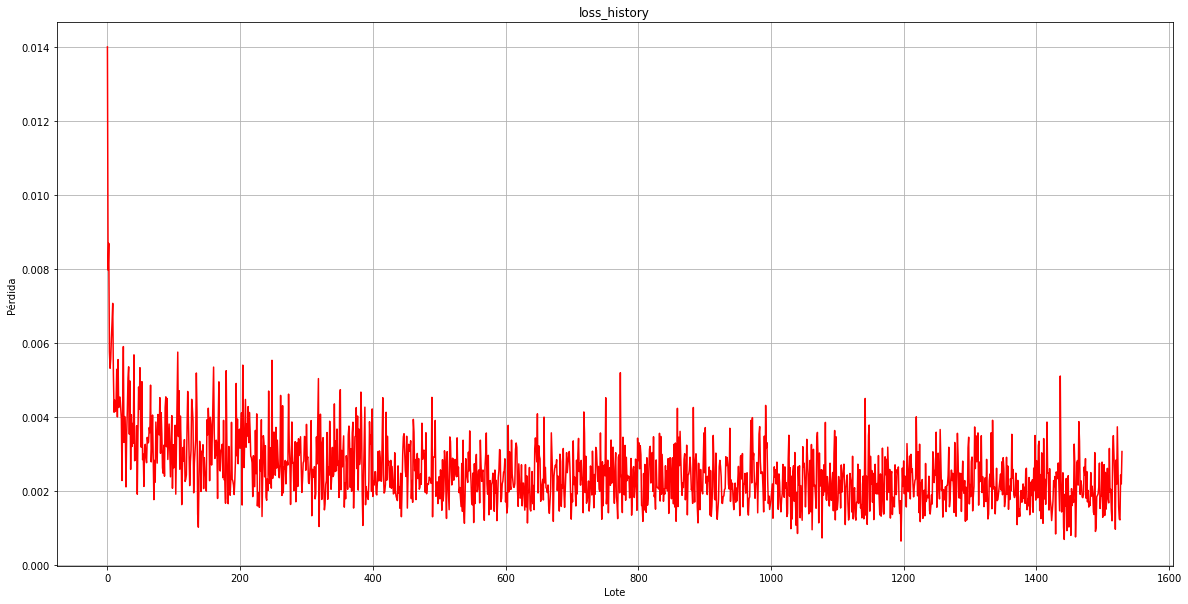

In [15]:
fig = plt.figure(figsize = (20, 10))
plt.plot(range(0,len(loss_history)), loss_history, 'r')
plt.title('loss_history')
plt.xlabel('Lote')
plt.ylabel('Pérdida')
plt.grid()
plt.show()

In [16]:
train_time_seconds = train_end-train_start
print("[time] Total training time: {:.3f}s = {:.3f}h".format(train_time_seconds, train_time_seconds/(60*60)))
print(f"[time] Time for each epoch:")
for i,x in enumerate(epoch_timing):
    print ("\t{:<5} {:.3f}s".format(i+1, x))

[time] Total training time: 6839.321s = 1.900h
[time] Time for each epoch:
	1     250.800s
	2     237.957s
	3     232.262s
	4     231.047s
	5     226.077s
	6     226.708s
	7     225.502s
	8     228.035s
	9     227.383s
	10    225.918s
	11    226.543s
	12    228.196s
	13    229.871s
	14    227.453s
	15    225.596s
	16    229.515s
	17    226.693s
	18    224.936s
	19    226.493s
	20    225.423s
	21    226.305s
	22    226.814s
	23    224.573s
	24    224.517s
	25    223.913s
	26    225.213s
	27    227.126s
	28    224.265s
	29    225.565s
	30    228.620s


# Guardado de la Red Neuronal

In [17]:
torch.save(red.state_dict(), DIR_models+dt_string+".pt")

# DEBUG

Esta celda y las siguientes son para testear. Han de ser eliminadas cuando se limpie el código de este *notebook*.

In [18]:
# Guardado de objetos.
with open(DIR_objects+dt_string+"_loss-history", "wb") as file:
    pickle.dump(loss_history, file)

In [19]:
# Cargado de objetos.
fecha = ""

#with open(DIR_objects+fecha+"_loss-history", "rb") as file:
    #pickle.dump(loss_history, file)

In [20]:
#f = birds_df.iloc[5][file_col_name]
#librosa_process(birds_path+f, True)

In [21]:
random.uniform(1,1)

1.0

In [22]:
print(*range(0,10))
print(*range(1,10))

0 1 2 3 4 5 6 7 8 9
1 2 3 4 5 6 7 8 9


In [23]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
print(dt_string)

17-01-2023-22-01-14


In [24]:
# Cargado de modelos.
fecha = ""

# Definimos un modelo que alojará a la Red Neuronal.
#modelo = RN().to(device)

# Actualizamos el modelo.
#modelo.load_state_dict(torch.load(DIR_models+fecha+".pt"))

# modelo.eval() le indica al modelo que ha de evaluar.
#modelo.eval()

In [25]:
print(len(birds_df))
print(len(birds_ds))
print(f"total_audios/batch_size = {len(birds_df)/batch_size}")

3277
3277
total_audios/batch_size = 51.203125
